In [32]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
real_dir = '/content/drive/My Drive/dataset/real'
fake_dir = '/content/drive/My Drive/dataset/fake'

In [34]:
import os

print("Real Images:", os.listdir(real_dir)[:5])  # Display first 5 images in real folder
print("Fake Images:", os.listdir(fake_dir)[:5])  # Display first 5 images in fake folder


Real Images: ['real_00118.jpg', 'real_00119.jpg', 'real_00114.jpg', 'real_00101.jpg', 'real_00110.jpg']
Fake Images: ['mid_470_1001.jpg', 'mid_471_1111.jpg', 'mid_469_1111.jpg', 'mid_474_1110.jpg', 'easy_8_0010.jpg']


In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
import numpy as np


In [36]:
# Parameters
IMG_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 1e-4
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Define custom dataset
class CustomDataset(Dataset):
    def __init__(self, image_dir, transform=None, label=0):
        self.image_dir = image_dir
        self.transform = transform
        self.label = label
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, self.label

# Transforms for the dataset
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


real_dataset = CustomDataset(real_dir, transform=transform, label=0)
fake_dataset = CustomDataset(fake_dir, transform=transform, label=1)

# Combine datasets
dataset = torch.utils.data.ConcatDataset([real_dataset, fake_dataset])

# Split into train and test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [37]:
# Load pre-trained ResNet50
resnet = models.resnet50(pretrained=True)

# Modify the final layer for binary classification
num_features = resnet.fc.in_features
resnet.fc = nn.Linear(num_features, 2)

# Move model to GPU/CPU
model = resnet.to(DEVICE)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 58.5MB/s]


In [38]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Training function
def train_model(model, train_loader, optimizer, criterion, epochs):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            # Zero the gradient
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Metrics
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss:.4f}, Accuracy: {accuracy:.2f}%")

# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    return y_true, y_pred


Epoch 1/10, Loss: 34.8136, Accuracy: 64.20%
Epoch 2/10, Loss: 16.5066, Accuracy: 87.57%
Epoch 3/10, Loss: 7.7299, Accuracy: 95.26%
Epoch 4/10, Loss: 6.4417, Accuracy: 95.74%
Epoch 5/10, Loss: 6.1932, Accuracy: 96.76%
Epoch 6/10, Loss: 3.6274, Accuracy: 97.78%
Epoch 7/10, Loss: 4.1937, Accuracy: 97.42%
Epoch 8/10, Loss: 5.8776, Accuracy: 97.60%
Epoch 9/10, Loss: 3.5011, Accuracy: 98.08%
Epoch 10/10, Loss: 2.0303, Accuracy: 99.10%


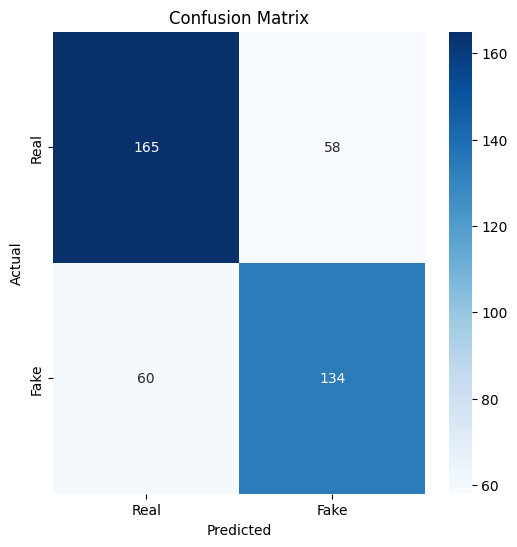

Classification Report:
              precision    recall  f1-score   support

        Real       0.73      0.74      0.74       223
        Fake       0.70      0.69      0.69       194

    accuracy                           0.72       417
   macro avg       0.72      0.72      0.72       417
weighted avg       0.72      0.72      0.72       417



In [39]:
# Train the model
train_model(model, train_loader, optimizer, criterion, EPOCHS)

# Evaluate the model
y_true, y_pred = evaluate_model(model, test_loader)

# Confusion matrix and classification report
conf_matrix = confusion_matrix(y_true, y_pred)

# Visualize confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Real', 'Fake']))
